In [36]:
%load_ext autoreload
%autoreload 2

from omegaconf import OmegaConf
import wandb_util.wandb_util as wbu
import multiprocessing as mp
mp.set_start_method('spawn', force=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
from scripts.wandb_experiments.benchmark import split_runs

exp_name = "benchmark_final"

runs = wbu.get_logged_runs(exp_name)
texture_runs, video_gen_runs = split_runs(runs)

print(wbu.get_exp_url(exp_name), len(video_gen_runs))

https://wandb.ai/romeu/diffusion-3D-features/groups/benchmark_final/workspace 24


In [38]:
from text3d2video.util import group_into_array, map_array

def scene_key(run):
    config = OmegaConf.create(run.config)
    return f"{config.animation_tag}-{config.prompt}-{config.seed}"

def method_key(run):
    return run.name.split("_")[0]

all_runs_grouped, all_labels = group_into_array(video_gen_runs, [method_key, scene_key])

In [41]:
import numpy as np

from text3d2video.util import index_list

method_indices = [1, 3, 2]
scene_indices = np.arange(len(all_runs_grouped[0])).tolist()
# scene_indices = [0]
runs_grouped = all_runs_grouped[np.ix_(method_indices, scene_indices)]

method_labels = index_list(all_labels[0], method_indices)
scene_labels = index_list(all_labels[1], scene_indices)
labels = [method_labels, scene_labels]

In [42]:
from text3d2video.experiment_analysis import VideoTraces

run_data = map_array(runs_grouped, VideoTraces.from_run, pbar=True)

100%|██████████| 18/18 [00:19<00:00,  1.09s/it]


In [43]:
from text3d2video.utilities.video_comparison import display_vids, video_grid
from text3d2video.utilities.video_util import pil_frames_to_clip

scene_i = 5
scene_run_data = run_data[:, scene_i]

uv_vid = pil_frames_to_clip(scene_run_data[0].seq.render_rgb_uv_maps())
prompt = scene_run_data[0].prompt
vids = map_array(scene_run_data, lambda x: pil_frames_to_clip(x.frames), pbar=True)

vid = video_grid([[uv_vid] + list(vids)], x_labels=[prompt, "Generative Rendering", "TexGen", "Ours"])
vid.write_videofile(f'outs/qual_greenlight/scene_{scene_i}.mp4')

100%|██████████| 3/3 [00:00<00:00,  9.98it/s]

                                   
                                   

Moviepy - Building video outs/qual_greenlight/scene_5.mp4.
Moviepy - Writing video outs/qual_greenlight/scene_5.mp4



Moviepy - Done !
Moviepy - video ready outs/qual_greenlight/scene_5.mp4


In [48]:
from text3d2video.utilities.video_comparison import display_vid


scene_i = 0
scene_run_data = run_data[:, scene_i]

uv_vid = pil_frames_to_clip(scene_run_data[0].seq.render_rgb_uv_maps())
prompt = scene_run_data[0].prompt
vids = map_array(scene_run_data, lambda x: pil_frames_to_clip(x.frames), pbar=True)[0:1]

vid = video_grid(
    [[uv_vid] + list(vids)],
    x_labels=[f'"{prompt}"', "Generative Rendering"],
)
display_vid(vid)
# vid.write_videofile(f'outs/qual_greenlight/scene_{scene_i}.mp4')

100%|██████████| 3/3 [00:00<00:00, 10.44it/s]


In [ ]:
from text3d2video.utilities.video_comparison import video_grid
from text3d2video.utilities.video_util import pil_frames_to_clip

vids = map_array(run_data, lambda run: pil_frames_to_clip(run.frames))
vid = video_grid(vids)

vid.write_videofile("outs/benchmark_qual_vid.mp4")

Moviepy - Building video outs/benchmark_qual_vid.mp4.
Moviepy - Writing video outs/benchmark_qual_vid.mp4



Moviepy - Done !
Moviepy - video ready outs/benchmark_qual_vid.mp4


In [ ]:
from einops import rearrange
from text3d2video.util import map_object_array, object_array, ordered_sample_indices

frame_indices = list(ordered_sample_indices(list(range(20)), 8))
ims = map_object_array(
    run_data, lambda x: object_array(index_list(x.frames, frame_indices))
)
ims = rearrange(ims, "method scene frame -> scene method frame")
ims.shape

(1, 3, 8)

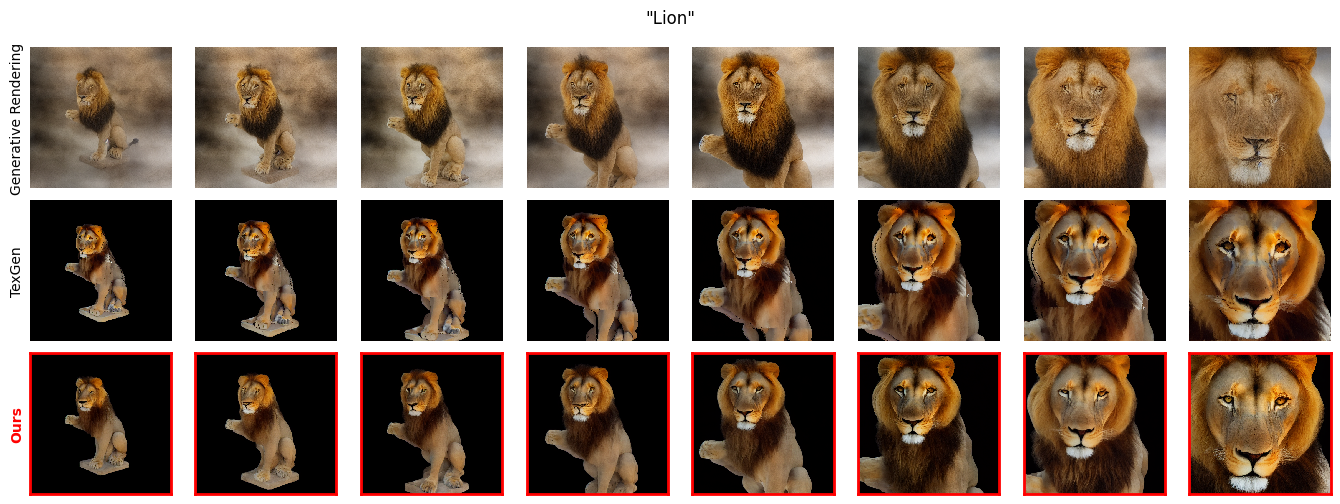

In [ ]:
from matplotlib import pyplot as plt
from text3d2video.utilities.ipython_utils import display_ims_grid

fig_scene_indices = list()

for scene_i in range(len(scene_indices)):
    scene_run = runs_grouped[0][scene_i]
    config = OmegaConf.create(scene_run.config)
    prompt = config.prompt
    tgt_tag = config.animation_tag
    fig, axs = display_ims_grid(
        ims[scene_i],
        row_titles=["Generative Rendering", "TexGen", "Ours"],
        scale=1.7,
        title=f'"{prompt}"',
        show=False,
    )

    axs[-1,0].set_ylabel("Ours", fontweight='bold', color='red')

    for ax in axs[-1,:]:
        for spine in ax.spines.values():
            spine.set_edgecolor('red')
            spine.set_linewidth(2)
            spine.set_visible(True)

    # plt.savefig(f"outs/qual/{tgt_tag}_{prompt}.pdf", bbox_inches="tight", dpi=300)
    plt.savefig(f"outs/teaser.pdf", bbox_inches="tight")